# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons

## Inicialização 

In [0]:
%matplotlib inline

import time

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 170008576/170498071 [00:23<00:00, 6046871.07it/s]

Files already downloaded and verified


In [0]:
train_loader = DataLoader(dataset=dataset_train, batch_size=50, 
                          shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=dataset_test, batch_size=50, 
                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Definindo as Arquiteturas MLP

In [0]:
# Arquitetura MLP com três Camadas Ocultas
class MLP1(nn.Module):
    
    # Construtor da Classe MLP
    def __init__(self):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)
        self.fc2 = nn.Linear(512,   256)
        self.fc3 = nn.Linear(256,   128)
        self.fc4 = nn.Linear(128,    10)
        self.activation_function = nn.ReLU()
    
    # Função Forward
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        x = self.activation_function(self.fc4(x))
        return x

# Arquitetura MLP com duas Camadas Ocultas
class MLP2(nn.Module):
    
    # Construtor da Classe MLP
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)
        self.fc2 = nn.Linear(512,    50)
        self.fc3 = nn.Linear(50,    10)
        self.activation_function = nn.ReLU()
    
    # Função Forward
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        return x
    

### Verificação se é possivel utilizar _cuda_

In [5]:
# Confere se pode utilizar cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imprime o dispotivo
print(device)

cuda:0


### Impressão dos modelos

In [0]:
# Vai ser necessário 6 modelos, pois temos 3 Otimizadores e 2 modelos MLP
# e será feito todas as combinações possiveis

# Inicializa os 6 modelos
models = []
for i in range(6):
    model = None
    if i % 2 == 0:
        model = MLP1()
    else:
        model = MLP2()
    models.append(model.to(device))

models_types = ('SGD + Model 1', 'SGD + Model 2',
                'ADAM + Model 1', 'ADAM + Model 2', 
                'RMSprop + Model 1', 'RMSprop + Model 2')    

# Imprime os modelos
#print(models)
#print(models_types)

# Definindo os Otimizadores e as Funções de Loss para cada Modelo

In [0]:
# Inicialização
i = 0
optimizers = []

# Os três primeiros utilizam SGD
for _ in range(2):
    optimizers.append(torch.optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9))
    i += 1

# Os três seguintes utilizam ADAM
for _ in range(2):
    optimizers.append(torch.optim.Adam(models[i].parameters(), lr=0.001))
    i += 1

# Os três ultimos utilizam RMSprop
for _ in range(2):
    optimizers.append(torch.optim.RMSprop(models[i].parameters(), lr=0.001, momentum=0.9))
    i += 1
    
#print(models_types)
#print(optimizers)

# Funções de Loss
loss_CE = nn.CrossEntropyLoss()

# Definindo a função de Treinamento

In [0]:
# Função de Treinamento 
def train(dataset, model, optimizer, loss_fn, epochs=15):
    
    # Vetor de Loss Inicializado
    loss_array = []
    
    # Percore pelo número de épocas
    for epoch in range(epochs):
        
        # Inicializa o running_loss em 0
        running_loss = 0.0
        
        # Percorre todo o dataset
        for i, data in enumerate(dataset, 0):

            # Pega a Entrada e o Label
            input, label = data
            
            # Transforma para o device
            input, label = input.to(device), label.to(device)

            # Zera os parâmetros dos gradientes
            optimizer.zero_grad()
            
            # Passa as entradas pelo modelo
            output = model(input)
            
            # Calcula o loss com a função escolhida
            loss = loss_fn(output, label)
            
            # Propaga o erro
            loss.backward()
            
            # Atualiza os pesos
            optimizer.step()
            
            # Soma ao loss
            running_loss += loss.item()
        
        # Imprime o loss desta época
        loss_array.append(running_loss/len(dataset))
        print('[%3d] loss: %.4f' %
             (epoch + 1, loss_array[-1]))
    
    # Retorna o array com os Loss em cada época
    return loss_array


# Definindo a Função de Avalaliação do Dataset por um modelo especifico

In [0]:

# Função de avaliação do modelo num conjunto passado
def evaluate(dataset, model, type_of_images='test'):
    
    # Inicialização
    correct, total = 0, 0
    
    # Percorre todo o dataset
    with torch.no_grad():
        for data in dataset:
            
            # Transforma para o device
            image, label = data
            image, label = image.to(device), label.to(device)
            
            # Recebe a saida do modelo
            output = model(image)
            
            # Faz o resultado dos labels das saidas
            _, predicted = torch.max(output.data, 1)
            
            # Confere se o resultado foi igual o label para dar acerto
            total += label.size(0)
            correct += (predicted == label).sum().item()
    
    # Imprime a acurácia do dataset para tal modelo
    print('Accuracy of the network on the %d %s images: %d %%' % 
          ( len(test_loader),  type_of_images, 100 * correct / total))
    
    # Retorna a acurácia
    return (100 * correct / total)


In [0]:
# __TREINAMENTO DOS MODELOS__

In [12]:
print(models_types)
loss_array = []
acuracies = []

('SGD + Model 1', 'SGD + Model 2', 'ADAM + Model 1', 'ADAM + Model 2', 'RMSprop + Model 1', 'RMSprop + Model 2')


### Utilizando SGD + Modelo 1

In [13]:
print(models_types[0])
loss_array.append(train(train_loader, models[0], optimizers[0], loss_CE))

SGD + Model 1
[  1] loss: 2.2972
[  2] loss: 2.2660
[  3] loss: 2.2106
[  4] loss: 2.1760
[  5] loss: 2.1356
[  6] loss: 2.0967
[  7] loss: 2.0719
[  8] loss: 2.0525
[  9] loss: 2.0338
[ 10] loss: 2.0156
[ 11] loss: 1.9954
[ 12] loss: 1.9468
[ 13] loss: 1.8886
[ 14] loss: 1.8572
[ 15] loss: 1.8231


### Utilizando SGD + Modelo 2

In [14]:
print(models_types[1])
loss_array.append(train(train_loader, models[1], optimizers[1], loss_CE))

SGD + Model 2
[  1] loss: 2.2798
[  2] loss: 2.2031
[  3] loss: 2.1387
[  4] loss: 2.1106
[  5] loss: 2.0914
[  6] loss: 2.0750
[  7] loss: 2.0610
[  8] loss: 2.0478
[  9] loss: 2.0346
[ 10] loss: 2.0213
[ 11] loss: 2.0088
[ 12] loss: 1.9960
[ 13] loss: 1.9841
[ 14] loss: 1.9736
[ 15] loss: 1.9624


### Utilizando ADAM + Modelo 1

In [15]:
print(models_types[2])
loss_array.append(train(train_loader, models[2], optimizers[2], loss_CE))

ADAM + Model 1
[  1] loss: 2.3027
[  2] loss: 2.3026
[  3] loss: 2.3026
[  4] loss: 2.3026
[  5] loss: 2.3026
[  6] loss: 2.3026
[  7] loss: 2.3026
[  8] loss: 2.3026
[  9] loss: 2.3026
[ 10] loss: 2.3026
[ 11] loss: 2.3026
[ 12] loss: 2.3026
[ 13] loss: 2.3026
[ 14] loss: 2.3026
[ 15] loss: 2.3026


### Utilizando ADAM + Modelo 2

In [16]:
print(models_types[3])
loss_array.append(train(train_loader, models[3], optimizers[3], loss_CE))

ADAM + Model 2
[  1] loss: 2.3027
[  2] loss: 2.3026
[  3] loss: 2.3026
[  4] loss: 2.3026
[  5] loss: 2.3026
[  6] loss: 2.3026
[  7] loss: 2.3026
[  8] loss: 2.3026
[  9] loss: 2.3026
[ 10] loss: 2.3026
[ 11] loss: 2.3026
[ 12] loss: 2.3026
[ 13] loss: 2.3026
[ 14] loss: 2.3026
[ 15] loss: 2.3026


### Utilizando RMSprop + Modelo 1

In [17]:
print(models_types[4])
loss_array.append(train(train_loader, models[4], optimizers[4], loss_CE))

RMSprop + Model 1
[  1] loss: 2.3341
[  2] loss: 2.3026
[  3] loss: 2.3026
[  4] loss: 2.3026
[  5] loss: 2.3026
[  6] loss: 2.3026
[  7] loss: 2.3026
[  8] loss: 2.3026
[  9] loss: 2.3026
[ 10] loss: 2.3026
[ 11] loss: 2.3026
[ 12] loss: 2.3026
[ 13] loss: 2.3026
[ 14] loss: 2.3026
[ 15] loss: 2.3026


### Utilizado RMSprop + Modelo 2

In [18]:
print(models_types[5])
loss_array.append(train(train_loader, models[5], optimizers[5], loss_CE))

RMSprop + Model 2
[  1] loss: 2.3296
[  2] loss: 2.3026
[  3] loss: 2.3026
[  4] loss: 2.3026
[  5] loss: 2.3026
[  6] loss: 2.3026
[  7] loss: 2.3026
[  8] loss: 2.3026
[  9] loss: 2.3026
[ 10] loss: 2.3026
[ 11] loss: 2.3026
[ 12] loss: 2.3026
[ 13] loss: 2.3026
[ 14] loss: 2.3026
[ 15] loss: 2.3026


## Gráficos da Loss em Cada Época para todos os modelos

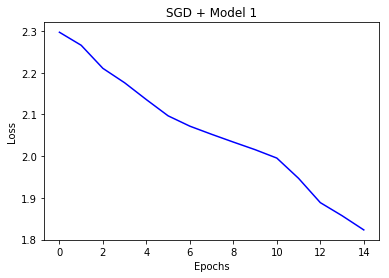

Accuracy of the network on the 200 test images: 35 %


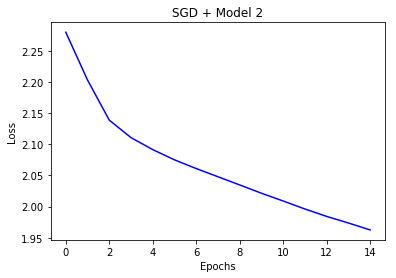

Accuracy of the network on the 200 test images: 32 %


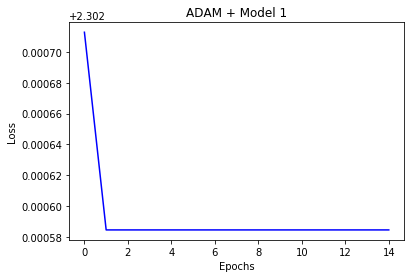

Accuracy of the network on the 200 test images: 10 %


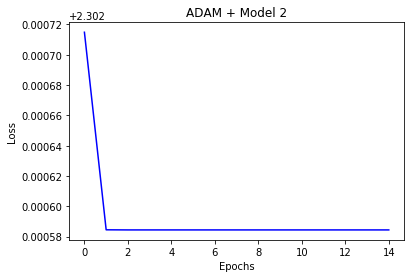

Accuracy of the network on the 200 test images: 10 %


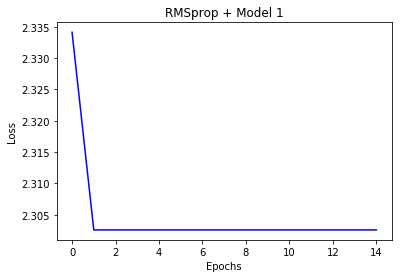

Accuracy of the network on the 200 test images: 10 %


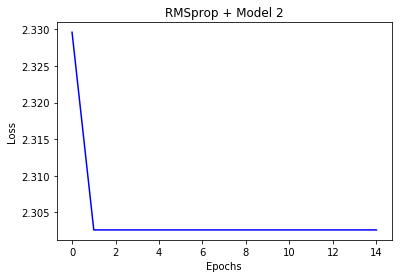

Accuracy of the network on the 200 test images: 10 %


In [24]:
acuracies = []
# Passa por Todos os modelos
for i in range(6):
    # Imprime o Gráfico de Desempenho de Loss
    plt.title(models_types[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss_array[i], 'b-')
    plt.show()
    
    # Imprime a acurácia do Dataset de Teste
    acuracies.append(evaluate(test_loader, models[i]))

## Gráficos de Barras diferenciando a acurácia entre cada modelo

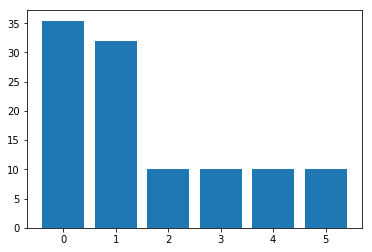

0 - SGD + Model 1
1 - SGD + Model 2
2 - ADAM + Model 1
3 - ADAM + Model 2
4 - RMSprop + Model 1
5 - RMSprop + Model 2


In [25]:
# Testar isso aqui
x = np.arange(6)

plt.bar(x, acuracies)
plt.xticks(x, x)
plt.show()

for i in range(6):
    print(i, '-', models_types[i])